In [49]:
import h5py, os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline

import ecog
from ecog.utils.electrodes import load_electrode_labels
from ecog.signal_processing import hilbert_transform, gaussian
from ecog.tokenize.transcripts import parse, make_df
from ecog.utils import bands
from ecog.signal_processing import zscore

In [217]:
subj_path = os.path.join(os.environ['HOME'], 'Development/data/ecog/EC2')
block = 'EC2_B1'
block_path = os.path.join(subj_path, block)
rate = 400

anatomy = load_electrode_labels(subj_path)
vsmc_idxs = np.array([idx for idx, a in enumerate(anatomy) if a in ['preCG', 'postCG']])

ec2_b1_transcript_parse = parse(block_path, block)
ec2_b1_transcript = make_df(ec2_b1_transcript_parse, 1, 'EC2', 1)

idx = (ec2_b1_transcript['label'] == 'raa').argmax()

def make_slice(idx, transcript, rate):
    align = transcript['align'].loc[idx]
    start_idx = int(rate * (align-.5))
    stop_idx = int(rate * (align + .8))
    return slice(start_idx, stop_idx)

def make_colors(n):
    colors = []
    for ii in range(n):
        if ii % 2 == 0:
            colors.append('k')
        else:
            colors.append('gray')
    return colors

sl = make_slice(idx, ec2_b1_transcript, rate)

In [218]:
with h5py.File(os.path.join(block_path, 'ecog400/ecog.h5')) as f:
    raw_vsmc_data = f['ecogDS/data'][sorted(vsmc_idxs)]
vsmc_data, means, stds = zscore(raw_vsmc_data, mode='file', sampling_freq=400., block_path=block_path)
baa_data = vsmc_data[:, sl]

# Electrodes by time

In [219]:
def plot_electrodes_by_time(data, ax):
    n_elec, n_time = data.shape
    cmap = matplotlib.cm.get_cmap('Reds')
    cs = make_colors(n_elec)
    x = np.linspace(-500, 800, n_time)
    for ii in range(n_elec):
        y = data[ii] / 3
        ax.plot(x, y + ii, c=cs[ii], lw=2.5)
    ax.set_xticks([-500, 0, 800])
    ax.set_yticks([])
    ax.set_yticklabels([None])
    ax.set_ylabel('Electrodes')
    ax.set_xlabel('Time (ms)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

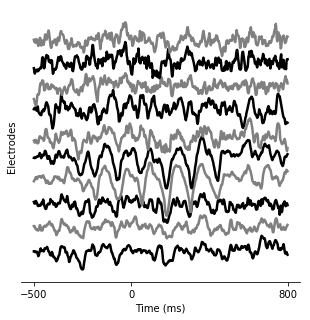

In [220]:
plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
plot_electrodes_by_time(baa_data[15:25], ax)
plt.savefig('/home/jesse/Downloads/electrodes.pdf')

# Bandpassed electrode

In [221]:
def plot_40bands_by_time(data, band_idxs, sl, ax):
    n_idxs = len(band_idxs)
    cs = make_colors(n_idxs)

    cfs = bands.chang_lab['cfs']
    stds = bands.chang_lab['sds']
    filters = [gaussian(data, rate, cfs[idx], stds[idx]) for idx in band_idxs]
    ht = np.squeeze(abs(hilbert_transform(data, rate, filters)))
    ht, means, stds = zscore(ht, mode='file', sampling_freq=400., block_path=block_path)
    ht = ht[:, sl]
    x = np.linspace(-500, 800, ht.shape[1])
    for ii in range(n_idxs):
        y = ht[ii] / 2
        ax.plot(x, y + ii, c=cs[ii], lw=3)
    ax.set_xticks([-500, 0, 800])
    ax.set_yticks(np.arange(n_idxs)[::3])
    ax.set_yticklabels(cfs.astype(int)[band_idxs][::3])
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Time (ms)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

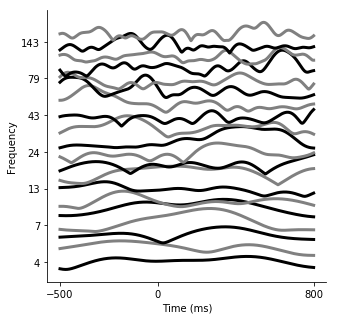

In [222]:
elec_idx = 19
elec_data = vsmc_data[[elec_idx]]
band_idxs = np.arange(0, 40, 2)

plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
plot_40bands_by_time(elec_data, band_idxs, sl, ax)
plt.savefig('/home/jesse/Downloads/frequencies.pdf')

# Neuro bands

In [223]:
def plot_neurobands_by_time(data, sl, ax):
    n_bands = len(bands.neuro['bands'])
    cs = make_colors(n_bands)
    cfs = bands.chang_lab['cfs']
    stds = bands.chang_lab['sds']
    
    for ii, (minf, maxf) in enumerate(zip(bands.neuro['min_freqs'], bands.neuro['max_freqs'])):
        filters = [gaussian(data, rate, c, s) for c, s in zip(cfs, stds) if ((c >= minf) and (c <= maxf))]
        ht = np.squeeze(abs(hilbert_transform(data, rate, filters)))
        ht, m, s = zscore(ht, mode='file', sampling_freq=400., block_path=block_path)
        ht = ht[:, sl].mean(axis=0) / 2
        x = np.linspace(-500, 800, ht.size)
        ax.plot(x, ht + ii, c=cs[ii], lw=3)
    ax.set_xticks([-500, 0, 800])
    ax.set_yticks(np.arange(n_bands))
    ax.set_yticklabels([r'$\theta$', r'$\alpha$', r'low $\beta$', r'high $\beta$', r'$\gamma$', r'high $\gamma$'])
    ax.set_ylabel('Frequency band')
    ax.set_xlabel('Time (ms)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

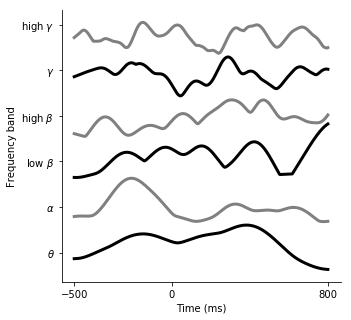

In [224]:
plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
plot_neurobands_by_time(elec_data, sl, ax)
plt.savefig('/home/jesse/Downloads/bands.pdf')

# Dataset

In [242]:
def plot_datapoints(data, slices, axes):
    n_elects, n_time = data.shape
    cs = make_colors(n_elects)
    cfs = bands.chang_lab['cfs']
    stds = bands.chang_lab['sds']
    
    minf = bands.neuro['min_freqs'][-1]
    maxf = bands.neuro['max_freqs'][-1]
    filters = [gaussian(data, rate, c, s) for c, s in zip(cfs, stds) if ((c >= minf) and (c <= maxf))]
    ht = abs(hilbert_transform(data, rate, filters)).mean(axis=0)
    ht, m, s = zscore(ht, mode='file', sampling_freq=400., block_path=block_path)
    for ii, (ax, sl) in enumerate(zip(axes, slices)):
        all_y = ht[:, sl] / 3
        x = np.linspace(-500, 800, all_y.shape[-1])
        for jj in range(n_elects):
            y = all_y[jj]
            ax.plot(x, y + jj, c=cs[jj], lw=3)
        ax.set_xticks([-500, 0, 800])
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.spines['left'].set_visible(False)
        if ii == 0:
            ax.set_ylabel(r'Electrodes high $\gamma$')
        if ii == (len(slices)-1):
            ax.set_xlabel('Time (ms)')
            ax.set_xticks([-500, 0, 800])
        else:
            ax.set_xticks([])

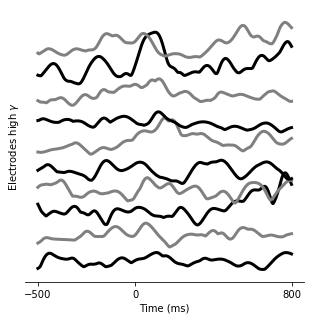

In [243]:
plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
plot_datapoints(vsmc_data[15:25], [sl], [ax])
plt.savefig('/home/jesse/Downloads/data.pdf')

# Network

In [244]:
def plot_network(n_nodes, n_layers, ax):
    xs = np.linspace(.1, .9, n_layers)
    ys = np.linspace(.1, .9, n_nodes)
    r = min((.9 - .1) / (2 * n_nodes), (.9 - .1) / (2 * n_layers))
    alpha = .3
    for y1 in ys:
        for y2 in ys:
            if abs(y2 - y1) < .5:
                for ii, x1 in enumerate(xs[:-1]):
                    x2 = xs[ii + 1]
                    ax.plot([x1 + r, x2 - r], [y1, y2], 'k', alpha=alpha)
    for y in np.linspace(.1, .9, n_nodes):
        for x in xs:
            ax.add_artist(Circle((x , y), r, fill=False))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

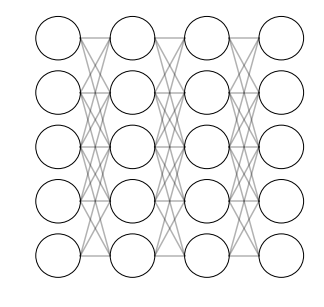

In [245]:
plt.close()
figsize = (5, 5)
f, ax = plt.subplots(1, figsize=figsize)
plot_network(5, 4, ax)
#plt.savefig('/home/jesse/Downloads/bands.pdf')

# Normal pipeline

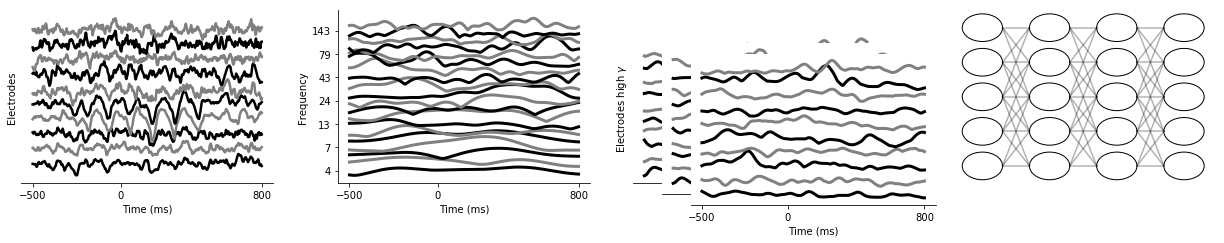

In [264]:
f = plt.figure(figsize=(20, 3))

ax0 = f.add_axes([.1, .1, .175, .8])
ax1 = f.add_axes([.32, .1, .175, .8])
n_data = 3
data_axes = [f.add_axes([.525+(ii*.02), .1-(ii*.05), .17, .7]) for ii in range(n_data)]
axn = f.add_axes([.75, .1, .175, .8])


plot_electrodes_by_time(baa_data[15:25], ax0)
plot_40bands_by_time(elec_data, band_idxs, sl, ax1)
plot_datapoints(vsmc_data[15:25], [make_slice(idx, ec2_b1_transcript, rate) for idx in [2, 23, 131]], data_axes)
plot_network(5, 4, axn)

plt.savefig('/home/jesse/Downloads/normal_pipeline.pdf')